# Compute KDE from MCMC chains

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from lace_manager.likelihood import marg_p1d_like

### Load a file containing the relevant parameters from a MCMC chain

In [2]:
simple_igm=True
delta_lnprob_cut=50
if simple_igm:
    fname='chain_igm_1.npz'
    kde_fname='kde_igm_1_cut_{}.npz'.format(delta_lnprob_cut)
else:
    fname='chain_igm_8.npz'
    kde_fname='kde_igm_8_cut_{}.npz'.format(delta_lnprob_cut)

In [3]:
data=np.load(fname)
x=data['Delta2_star']
y=data['n_star']
lnprob=data['lnprob']
# get rid of low-probability islands
max_lnprob=np.max(lnprob)
if delta_lnprob_cut:
    mask=(max_lnprob-lnprob<delta_lnprob_cut)
    print('will use {} / {} points'.format(np.sum(mask),len(lnprob)))
    x=x[mask]
    y=y[mask]
    lnprob=lnprob[mask]
prob=np.exp(lnprob-max_lnprob)

will use 136400 / 140800 points


### Setup KDE from chain

In [4]:
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
print('{:.3f} < Delta2_star < {:.3f}'.format(xmin,xmax))
print('{:.3f} < n_star < {:.3f}'.format(ymin,ymax))

0.308 < Delta2_star < 0.383
-2.314 < n_star < -2.284


In [5]:
mean_D2_star=np.mean(x)
mean_n_star=np.mean(y)
print('Delta2_star (mean) =',mean_D2_star)
print('n_star (mean) =',mean_n_star)

Delta2_star (mean) = 0.345145832252187
n_star (mean) = -2.3001559441563177


In [6]:
max_lnprob=np.max(lnprob)
imax=np.where(lnprob==max_lnprob)
max_like_D2_star=x[imax][0]
max_like_n_star=y[imax][0]
print('Delta2_star (max like) =',max_like_D2_star)
print('n_star (max like) =',max_like_n_star)

Delta2_star (max like) = 0.34539607293843166
n_star (max like) = -2.29993577412336


In [7]:
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

In [8]:
# best-fit values from KDE
kde_max_D2_star=X[Z==np.max(Z)][0]
kde_max_n_star=Y[Z==np.max(Z)][0]
print('Delta2_star (KDE) =',kde_max_D2_star)
print('n_star (KDE) =',kde_max_n_star)

Delta2_star (KDE) = 0.3462446926443452
n_star (KDE) = -2.2997616151758487


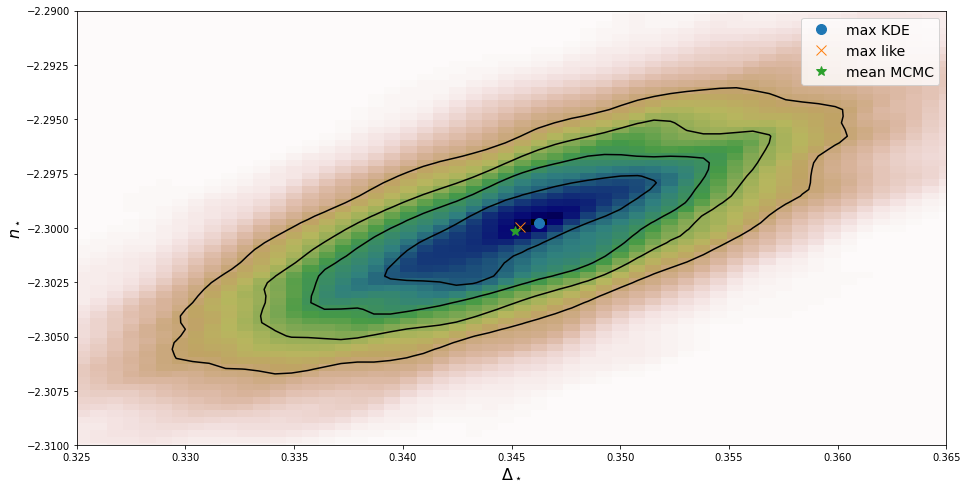

In [9]:
plt.figure(figsize=[16,8])
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax],label='density')
if simple_igm:
    plt.xlim(0.325,0.365)
    plt.ylim(-2.31,-2.29)
else:
    plt.xlim(0.31,0.39)
    plt.ylim(-2.33,-2.27)
#plt.plot(x, y, 'k.', markersize=0.1)
plt.contour(X,Y,Z,5,colors='k')
plt.plot(kde_max_D2_star,kde_max_n_star,'o',markersize=10,label='max KDE')
plt.plot(max_like_D2_star,max_like_n_star,'x',markersize=10,label='max like')
plt.plot(mean_D2_star,mean_n_star,'*',markersize=10,label='mean MCMC')
plt.xlabel(r'$\Delta_\star$',fontsize=16)
plt.ylabel(r'$n_\star$',fontsize=16)
plt.legend(fontsize=14)
#plt.colorbar()

# Interpolate on KDE

In [10]:
from scipy import interpolate

In [11]:
# make copy of KDE
newZ=np.copy(Z)
newX=np.copy(X)
newY=np.copy(Y)

In [12]:
kde_interp=interpolate.RectBivariateSpline(np.unique(newX),np.unique(newY),newZ)

In [13]:
# evaluate KDE on new grid
Nj=500j
X2, Y2 = np.mgrid[xmin:xmax:Nj, ymin:ymax:Nj]
Z2=kde_interp.ev(X2,Y2)

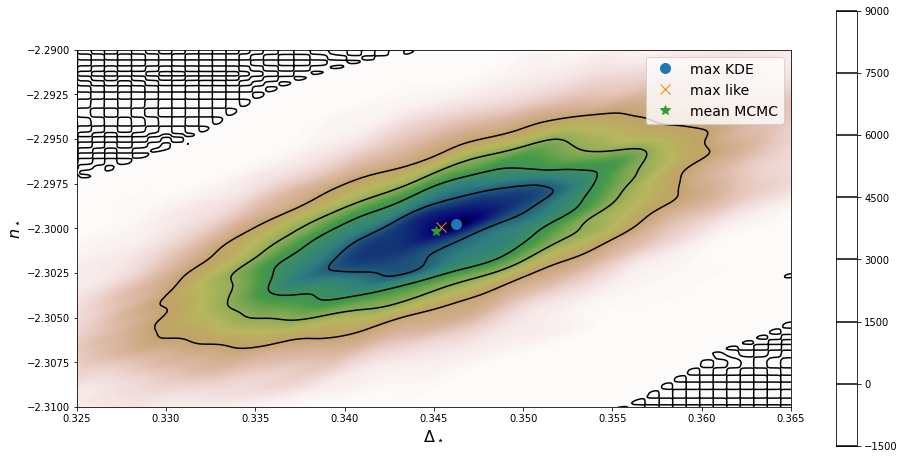

In [14]:
plt.figure(figsize=[16,8])
plt.imshow(np.rot90(Z2), cmap=plt.cm.gist_earth_r,extent=[xmin, xmax, ymin, ymax],label='density')
if simple_igm:
    #plt.plot(x, y, 'k.', markersize=0.2)
    plt.xlim(0.325,0.365)
    plt.ylim(-2.31,-2.29)
else:
    #plt.plot(x, y, 'k.', markersize=0.1)
    plt.xlim(0.31,0.39)
    plt.ylim(-2.33,-2.27)
#plt.plot(x, y, 'k.', markersize=0.1)
plt.contour(X2,Y2,Z2,5,colors='k')
plt.plot(kde_max_D2_star,kde_max_n_star,'o',markersize=10,label='max KDE')
plt.plot(max_like_D2_star,max_like_n_star,'x',markersize=10,label='max like')
plt.plot(mean_D2_star,mean_n_star,'*',markersize=10,label='mean MCMC')
plt.xlabel(r'$\Delta_\star$',fontsize=16)
plt.ylabel(r'$n_\star$',fontsize=16)
plt.legend(fontsize=14)
plt.colorbar()

# Read / Write KDE from / to file

In [15]:
def write_KDE(fname,Nj=100j,delta_lnprob_cut=100,bw_method=None):
    # get chain points and probabilities
    # maximum likelihood points
    max_lnprob=np.max(lnprob)
    print('max lnprob',max_lnprob)
    imax=np.where(lnprob==max_lnprob)
    max_like_D2_star=x[imax][0]
    max_like_n_star=y[imax][0]
    print('Delta2_star (max like) =',max_like_D2_star)
    print('n_star (max like) =',max_like_n_star)
    # setup regular 2D grid for KDE
    X, Y = np.mgrid[xmin:xmax:Nj, ymin:ymax:Nj]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values,bw_method=bw_method)
    Z = np.reshape(kernel(positions).T, X.shape)
    # max-like values from KDE
    kde_max_D2_star=X[Z==np.max(Z)][0]
    kde_max_n_star=Y[Z==np.max(Z)][0]
    print('Delta2_star (max KDE) =',kde_max_D2_star)
    print('n_star (max KDE) =',kde_max_n_star)
    # store to file
    np.savez(fname, D2_star=np.unique(X),
             n_star=np.unique(Y), density=Z)

In [16]:
def read_KDE(fname):
    data = np.load(fname)
    Delta2_star=data['D2_star']
    n_star=data['n_star']
    counts=data['density']
    return Delta2_star, n_star, counts

In [17]:
write_KDE(fname=kde_fname,Nj=100j,delta_lnprob_cut=50,bw_method=None)

max lnprob 178.43656773969963
Delta2_star (max like) = 0.34539607293843166
n_star (max like) = -2.29993577412336
Delta2_star (max KDE) = 0.3462446926443452
n_star (max KDE) = -2.2997616151758487


In [18]:
Delta2_star, n_star, counts = read_KDE(kde_fname)

Text(0.5, 1.0, 'normalised counts')

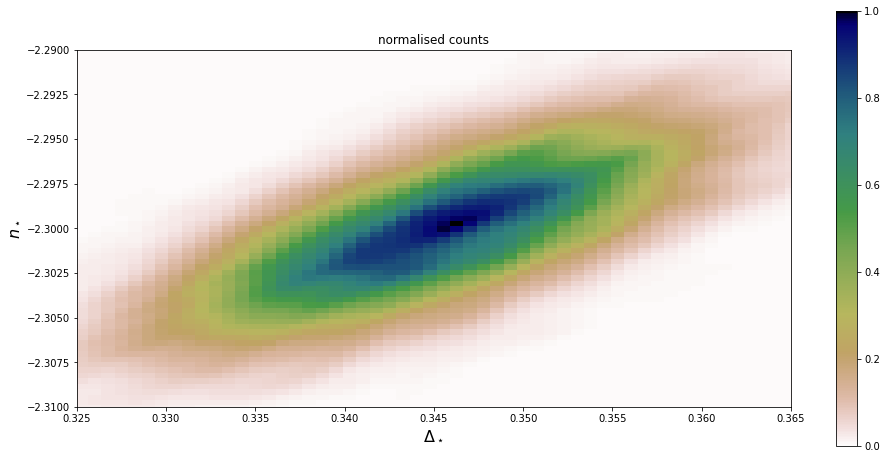

In [19]:
max_counts=np.max(counts)
plt.figure(figsize=[16,8])
plt.imshow(np.rot90(counts/max_counts), cmap=plt.cm.gist_earth_r,
           extent=[np.min(Delta2_star),np.max(Delta2_star),
                   np.min(n_star),np.max(n_star)])
if simple_igm:
    plt.xlim(0.325,0.365)
    plt.ylim(-2.31,-2.29)
else:
    plt.xlim(0.31,0.39)
    plt.ylim(-2.33,-2.27)
plt.xlabel(r'$\Delta_\star$',fontsize=16)
plt.ylabel(r'$n_\star$',fontsize=16)
plt.colorbar()
plt.title('normalised counts')

# Use new KDE object

In [20]:
from lace_manager.likelihood import marg_p1d_like

In [21]:
marg_p1d=marg_p1d_like.MargP1DLike(kde_fname=kde_fname)

will setup marg_p1d from KDE file kde_igm_1_cut_50.npz


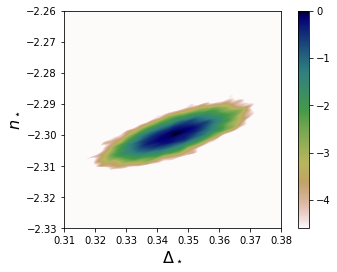

In [22]:
marg_p1d.plot_log_like(min_Delta2_star=0.31,max_Delta2_star=0.38)